# Introduction


This notebook explores methods for improving stability of the PAM demand modelling outputs.

In [17]:
import os
import pandas as pd
import random
from copy import deepcopy
from collections import defaultdict
import geopandas as gp
from matplotlib import pyplot as plt
from pam import read
from pam.policy import policies, modifiers, probability_samplers, filters
import matplotlib.pyplot as plt
from pam.activity import Plan, Activity, Leg
import seaborn as sns
import numpy as np
import scipy.stats as st

## Load Data

In [18]:
data_path = os.path.join("data", "example_data")
trips = pd.read_csv(os.path.join(data_path, 'example_travel_diaries_long.csv'))
attributes = pd.read_csv(os.path.join(data_path, 'example_attributes_long.csv'), index_col="pid")

In [19]:
attributes['age'] = [int(a) for a in np.random.normal(40.5, 10, len(attributes))]

In [20]:
def print_simple_stats(population):
    """
    Print some simple population statistics.
    """
    time_at_home = 0
    travel_time = 0 
    low_income_central_trips = 0
    high_income_central_trips = 0
    
    for hid, hh in population.households.items():
        for pid, person in hh.people.items():
            freq = person.freq
            
            for p in person.plan:
                if p.act == 'travel':
                    duration = p.duration.seconds * freq / 3600
                    travel_time += duration
                    
                    if p.end_location.area == "Westminster,City of London":
                        if person.attributes['inc'] == "low":
                            low_income_central_trips += freq
                            
                        elif person.attributes['inc'] == "high":
                            high_income_central_trips += freq
                    
                else:  # activity
                    if p.act == 'home':
                        duration = p.duration.seconds * freq / 3600
                        time_at_home += duration
                        
    print(f"Population total time at home: {time_at_home/1000000:.2f} million hours")
    print(f"Population total travel time: {travel_time/1000000:.2f} million hours")
    print(f"Low income trips to Central London: {low_income_central_trips} trips")
    print(f"High income trips to Central London: {high_income_central_trips} trips")

## Create the population and policies

In [21]:
zone_filter = ['Camden','Hammersmith and Fulham', 'Brent']
new_trips_filtered = trips[
    (trips.ozone.isin(zone_filter))&\
    (trips.dzone.isin(zone_filter))
]

new_trips_filtered.ozone.unique()
population = read.load_travel_diary(new_trips_filtered, attributes, trip_freq_as_person_freq=True)

def apply_policies(population, policies: list):

    new_population = deepcopy(population) 
    for hid, household in new_population.households.items():
        for policy in policies:
            policy.apply_to(household)
    return new_population

def age_condition_over_17(attribute_value):
    return attribute_value > 17

policy_remove_higher_education = \
    policies.PersonPolicy(
        modifiers.RemoveActivity(['education']),
        probability_samplers.PersonProbability(1),
        filters.PersonAttributeFilter({'age': age_condition_over_17}, how='all')
)

policy_remove_leisure = \
    policies.PersonPolicy(
        modifiers.RemoveActivity(['leisure']), 
        probability_samplers.PersonProbability(1)
)


policy_remove_health = \
    policies.ActivityPolicy(
        modifiers.RemoveActivity(['health']), 
        probability_samplers.ActivityProbability(['health'], 0.5)
)

policy_unemployment_and_furlough = \
    policies.PersonPolicy(
        modifiers.RemoveActivity(['work']), 
        probability_samplers.PersonProbability(0.1)
)

policy_work_from_home = \
    policies.PersonPolicy(
        modifiers.RemoveActivity(['work']), 
        probability_samplers.PersonProbability(0.5)
)

policy_reduced_work_activity = \
    policies.ActivityPolicy(
        modifiers.RemoveActivity(['work']), 
        probability_samplers.ActivityProbability(['work'], 0.2)
)

policy_remove_shopping = \
    policies.ActivityPolicy(
        modifiers.RemoveActivity(['shop']), 
        probability_samplers.ActivityProbability(['shop'], 0.5)
)

Using tour based purpose parser (recommended)
/Users/fred.shone/.ve/pam/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

Adding pid->hh mapping to persons_attributes from trips.
Adding home locations to persons attributes using trips attributes.
Using freq of 'None' for all trips.
/Users/fred.shone/Projects/pam/pam/read/diary.py:248: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Test model stability

In [22]:
def get_demand_matrix(population):
    ods = []
    for hid, hh in population.households.items():
        for pid, person in hh.people.items():
            for act in person.plan:
                if isinstance(act, Leg):
                    ods.append((act.start_location.area, act.end_location.area))
    ods = pd.DataFrame(ods)
    ods.columns = ['origin', 'destination']
    ods = ods.groupby(['origin','destination'])[['destination']].count()
    ods.columns = ['trips']
    return ods


def plot_heatmap(df, figsize=(19, 7)):
    """
    Plot an OD demand heatmap
    """
    plt.figure(figsize=figsize)
    sns.heatmap(
        df,
        annot=False,
        cmap=cm.coolwarm,
        linewidths=0.5
    )
    
def run_policies(population):
    """
    Apply a mix of policies and return a new population
    """
    all_together_pop = apply_policies(
    population, 
    [policy_remove_higher_education, 
     policy_remove_leisure, 
     policy_remove_health, 
     policy_unemployment_and_furlough, 
     policy_work_from_home, 
     policy_reduced_work_activity, 
     policy_remove_shopping])
    
    return all_together_pop


In [23]:
for hid, pid, p in population.people():
    if "age" not in p.attributes:
        print(hid, pid)

We apply a mix of policies in our simplified demand matrix:

In [24]:
pop1 = run_policies(population)
print_simple_stats(pop1)
get_demand_matrix(pop1).unstack(level='destination')

Population total time at home: 0.39 million hours
Population total travel time: 0.01 million hours
Low income trips to Central London: 0 trips
High income trips to Central London: 0 trips


trips                              
destination            Brent Camden Hammersmith and Fulham
origin                                                    
Brent                     20      1                      6
Camden                     1      8                      3
Hammersmith and Fulham     6      3                      4

... however we get a different answer every time we apply the same policy:

In [25]:
pop2 = run_policies(population)
print_simple_stats(pop2)
get_demand_matrix(pop2).unstack(level='destination')

Population total time at home: 0.31 million hours
Population total travel time: 0.01 million hours
Low income trips to Central London: 0 trips
High income trips to Central London: 0 trips


trips                              
destination            Brent Camden Hammersmith and Fulham
origin                                                    
Brent                     14      4                      1
Camden                     4      6                      3
Hammersmith and Fulham     1      3                      6

Similarly, the spatial patterns of demand change can vary:

Demand Change - First iteration of policy application: 


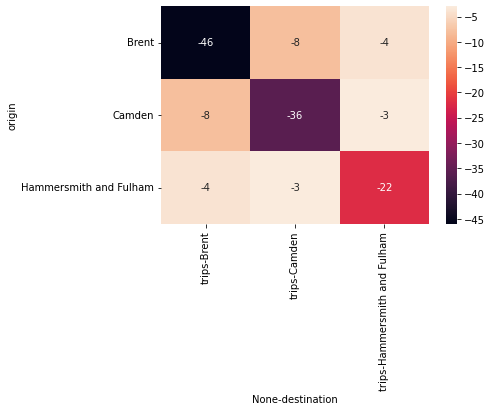

In [26]:
print('Demand Change - First iteration of policy application: ')
demand_diff = get_demand_matrix(pop1).unstack(level='destination') - \
get_demand_matrix(population).unstack(level='destination')
sns.heatmap(demand_diff, annot=True)
plt.show()

Demand Change - Second iteration of policy application: 


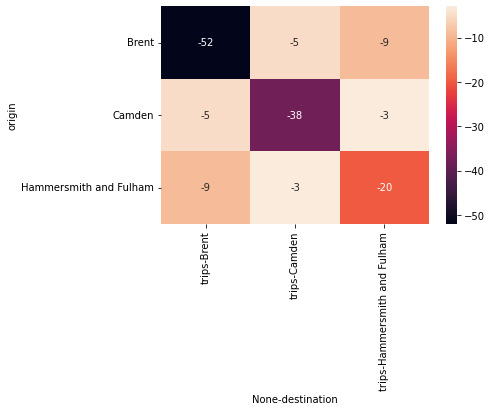

In [27]:
print('Demand Change - Second iteration of policy application: ')
demand_diff = get_demand_matrix(pop2).unstack(level='destination') - \
get_demand_matrix(population).unstack(level='destination')
sns.heatmap(demand_diff, annot=True)
plt.show()

In [28]:
def get_travel_time(population):
    """
    Return total travel time
    """
    time_at_home = 0
    travel_time = 0 
    low_income_central_trips = 0
    high_income_central_trips = 0
    
    for hid, hh in population.households.items():
        for pid, person in hh.people.items():
            freq = person.freq
            
            for p in person.plan:
                if p.act == 'travel':
                    duration = p.duration.seconds * freq / 3600
                    travel_time += duration
                    
                    if p.end_location.area == "Westminster,City of London":
                        if person.attributes['inc'] == "low":
                            low_income_central_trips += freq
                            
                        elif person.attributes['inc'] == "high":
                            high_income_central_trips += freq
                    
                else:  # activity
                    if p.act == 'home':
                        duration = p.duration.seconds * freq / 3600
                        time_at_home += duration
    
    return travel_time
                         
def run_stats(population):
    """
    Run policies and return total travel time
    """
    all_together_pop = run_policies(population)    
    return get_travel_time(all_together_pop)


def get_conf_interval(res_it):
    """
    Get the confidence interval of total travel time
    """
    it_mean = np.mean(res_it)
    print('Average time: {:,.0f} hours'.format(it_mean))
    it_interval=st.t.interval(0.95, len(res_it)-1, loc=it_mean, scale=st.sem(res_it))
    print('Confidence interval (95%): {:,.0f} to {:,.0f}'.format(it_interval[0], it_interval[1]))
    

The plot below shows the variance of total travel time between iterations of applying the same set of policies:

Average time: 7,020 hours
Confidence interval (95%): 6,192 to 7,848


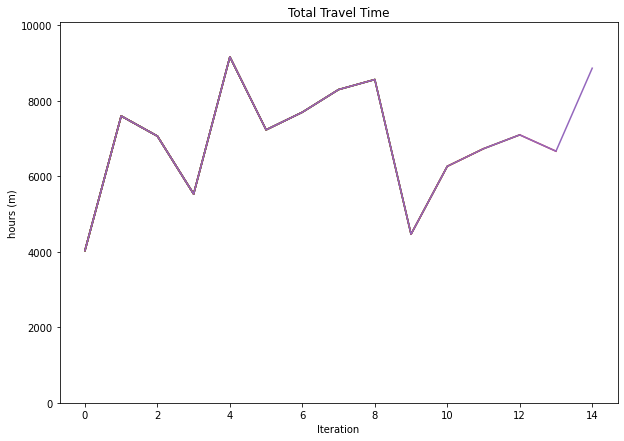

In [29]:
res = []
plt.figure(figsize=(10,7))
for i in range(15):
    res.append(run_stats(population))
    plt.plot(res)
    plt.title('Total Travel Time')
    plt.xlabel('Iteration')
    plt.ylim(0, max(res)*1.1)
    plt.ylabel('hours (m)')

get_conf_interval(res)

Averaging across a batch run of the policy application improves stability significantly: 

Average time: 6,989 hours
Confidence interval (95%): 6,880 to 7,097


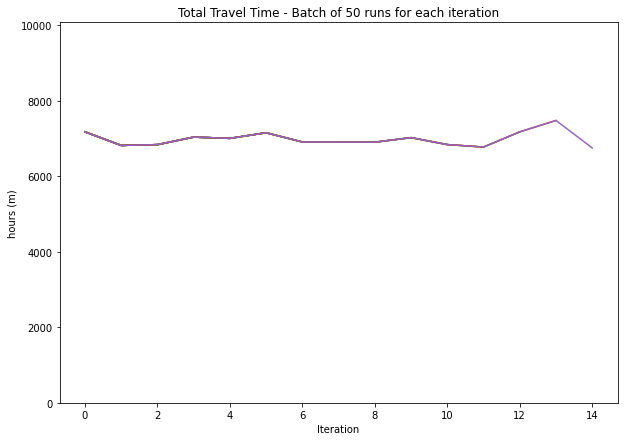

In [30]:
def run_batch_policy(population, n=50):
    res_av=[]
    for i in range(n):
        res_av.append(run_stats(population))
    return sum(res_av)/len(res_av)

res_batch = []
plt.figure(figsize=(10,7))
for i in range(15):
    res_batch.append(run_batch_policy(population))
    plt.plot(res_batch)
    plt.title('Total Travel Time - Batch of 50 runs for each iteration')
    plt.ylim(0, max(res)*1.1)
    plt.xlabel('Iteration')
    plt.ylim(0, max(res)*1.1)
    plt.ylabel('hours (m)')
    
get_conf_interval(res_batch)

We can also improve convergence by iterating through the policy application until the `running average` time stabilises:

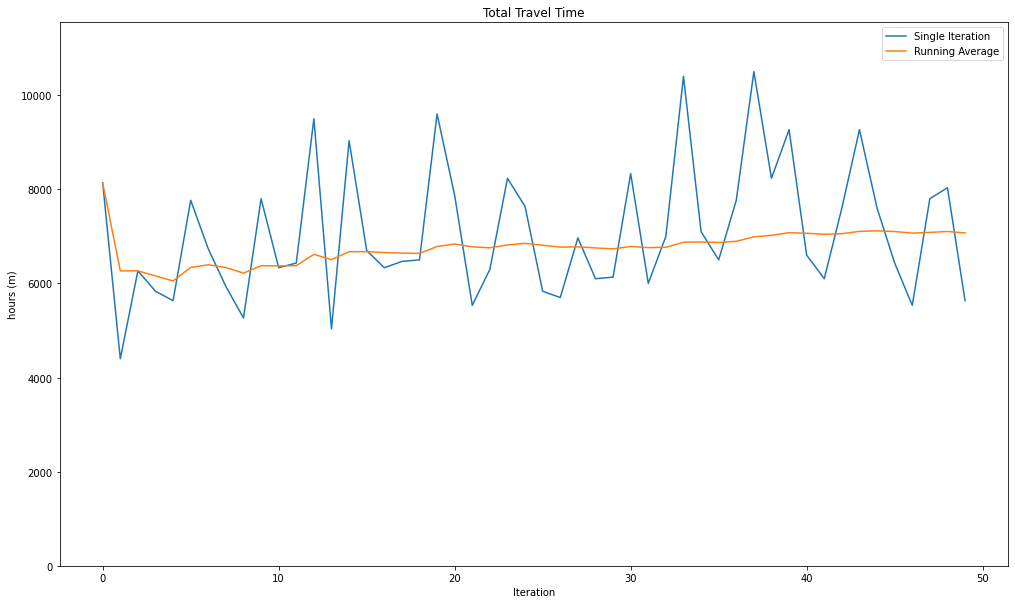

In [31]:
#gradual convergence
res_it=[]
res_conv=[]
def converge(population, n=50):
    for i in range(n):
        res_it.append(run_stats(population))
        res_conv.append(sum(res_it)/len(res_it))
    plt.figure(figsize=(17,10))
    plt.plot(res_it)
    plt.plot(res_conv)
    plt.title('Total Travel Time')
    plt.ylim(0, max(res_it)*1.1)
    plt.xlabel('Iteration')
    plt.ylabel('hours (m)')
    plt.legend(['Single Iteration','Running Average'])
    
converge(population)

We can set a threshold that signifies convergence, for example: when a new iteration changes the averaged results by less than 1% (see plot below).

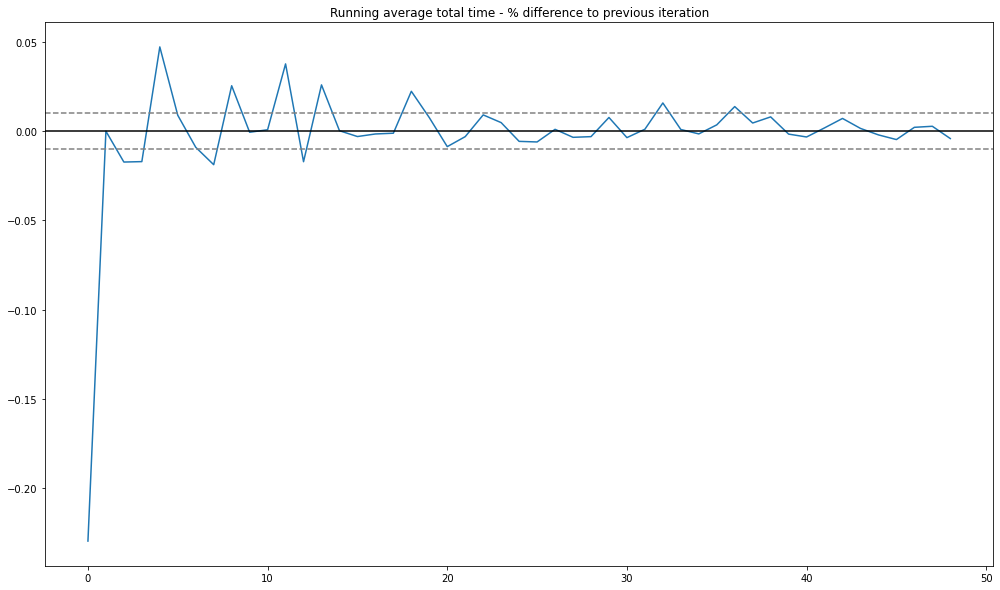

In [32]:
res_conv_diff = []
for i in range(1,len(res_conv)):
    res_conv_diff.append((res_conv[i]/res_conv[i-1])-1)
plt.figure(figsize=(17,10))
plt.plot(res_conv_diff)
plt.title('Running average total time - % difference to previous iteration')
plt.axhline(0, c='black')
plt.axhline(0.01, linestyle='dashed',c='grey')
plt.axhline(-0.01, linestyle='dashed',c='grey')
plt.show()